In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

tickers = ['AAPL', 'AMD', 'AMZN', 'CCJ', 'COST', 'GOOG', 'GS', 'JPM', 'LLY', 'META', 'MSFT', 'NEE', 'PFE', 'SAP', 'WMT']

In [110]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  15 of 15 completed


,AAPL,AMD,AMZN,CCJ,COST,GOOG,GS,JPM,LLY,META,MSFT,NEE,PFE,SAP,WMT
Date,,,,,,,,,,,,,,,
2023-06-15,186.009995,124.239998,127.110001,31.639999,529.179993,125.790001,339.739990,143.089996,453.929993,281.829987,348.100006,74.360001,39.750000,137.039993,157.729996
2023-06-16,184.919998,120.080002,125.489998,31.760000,523.650024,124.059998,338.309998,143.259995,447.709991,281.000000,342.329987,75.589996,40.060001,137.279999,155.529999
2023-06-20,185.009995,118.930000,125.779999,31.950001,519.700012,123.849998,330.720001,142.529999,451.950012,284.329987,338.049988,74.760002,39.340000,136.009995,154.160004
2023-06-21,183.960007,112.110001,124.830002,31.350000,519.619995,121.260002,325.070007,142.320007,453.000000,281.640015,333.559998,75.779999,38.900002,134.789993,154.460007
2023-06-22,187.000000,110.699997,130.149994,30.870001,524.200012,123.870003,319.579987,139.580002,457.679993,284.880005,339.709991,75.129997,38.730000,135.110001,155.750000


In [111]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    25.029367
1993-02-01    25.207388
1993-02-02    25.260796
1993-02-03    25.527822
1993-02-04    25.634630
Name: Adj Close, dtype: float64

In [112]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'AAPL': 2941266952192,
 'AMD': 178266849280,
 'AMZN': 1335391027200,
 'CCJ': 13482627072,
 'COST': 232334360576,
 'GOOG': 1569172750336,
 'GS': 106243727360,
 'JPM': 407893245952,
 'LLY': 434463277056,
 'META': 730070515712,
 'MSFT': 2525910269952,
 'NEE': 152019533824,
 'PFE': 221115760640,
 'SAP': 157782818816,
 'WMT': 419409821696}

In [113]:
import pypfopt
pypfopt.__version__

'1.5.5'

In [114]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.5827491868968573

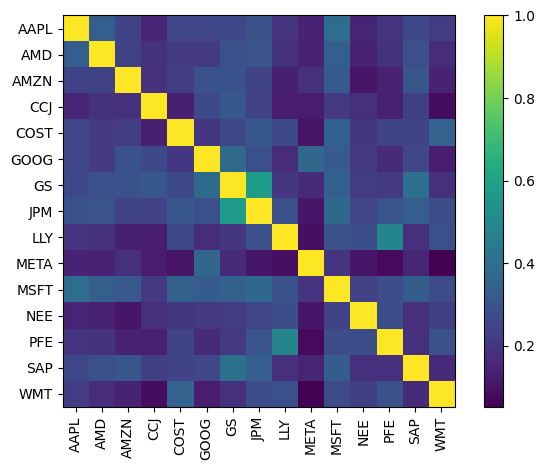

In [115]:
plotting.plot_covariance(S, plot_correlation=True);

In [116]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL    0.193584
AMD     0.155113
AMZN    0.141247
CCJ     0.064891
COST    0.080536
GOOG    0.070690
GS      0.082316
JPM     0.105892
LLY     0.072287
META    0.051484
MSFT    0.132005
NEE     0.052756
PFE     0.071500
SAP     0.086406
WMT     0.077127
dtype: float64

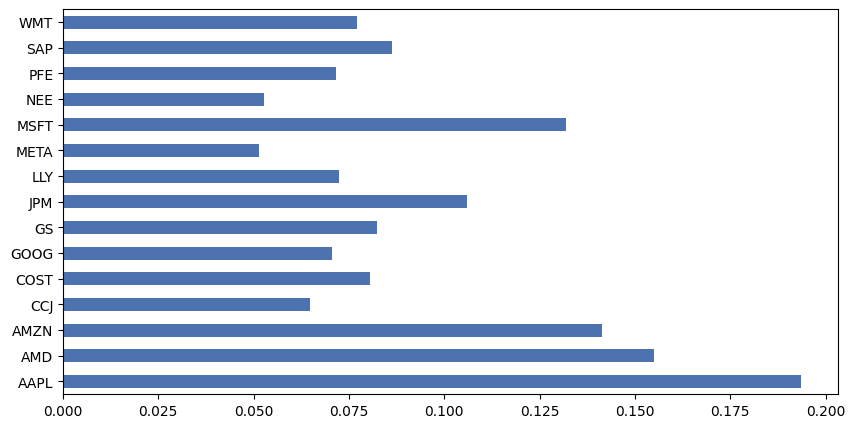

In [117]:
market_prior.plot.barh(figsize=(10,5));

In [118]:
# You don't have to provide views on all the assets
viewdict = {
    "AAPL": 0.03,
    "AMD": 0.10,
    "AMZN": 0.035,
    "CCJ": 0.10,
    "COST": 0.05,
    "GOOG": 0.04,
    "GS": -0.02,
    "JPM": 0.05,
    # "LLY": -0.1,
    "META": 0.05,
    "MSFT": 0.20,
    "NEE": 0.12,
    # "PFE": -0.08,
    # "SAP": -0.04,
    "WMT": 0.03}


bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [119]:
confidences = [
    0.6,
    0.6,
    0.2,
    0.3,
    0.7, # confident in COSTCO
    0.5, 
    0.2, 
    0.4,
    # 0.3,
    0.5,
    0.4,
    0.6,
    # 0.3,
    # 0.6,
    0.4
]

In [120]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

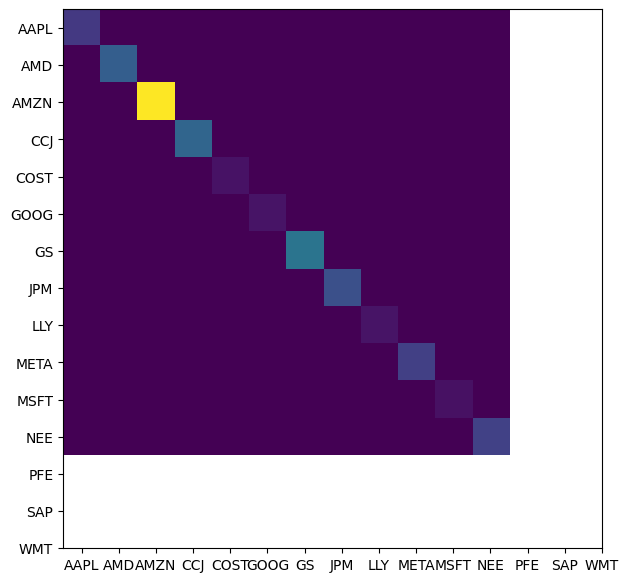

In [108]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [84]:
np.diag(bl.omega)

array([0.00553857, 0.00997008, 0.03328802, 0.01085784, 0.00156193,
       0.00176759, 0.0128359 , 0.00807516, 0.00852637, 0.00180038,
       0.00626494, 0.00152282, 0.00885492, 0.00277553, 0.0064974 ])

In [85]:
# intervals = [
#     (0, 0.10),
#     (0, 0.20),
#     (0, 0.1),
#     (0, 0.10),
#     (0, 0.20),
#     (0, 0.20),
#     (-0.20, 0),
#     (0, 0.10),
#     (0, 0.30),
#     (0, 0.10),
#     (0, 0.40),
#     (0, 0.10),
#     (-0.30, 0),
#     (-0.10, 0),
#     (0, 0.10)
# ]

intervals = [
    (-0.03, 0.09),
    (-0.1, 0.3),
    (-0.035, 0.105),
    (-0.1, 0.3),
    (-0.05, 0.15),
    (-0.04, 0.12),
    (-0.02, 0.06),
    (-0.05, 0.15),
    (-0.1, 0.3),
    (-0.05, 0.15),
    (-0.2, 0.6),
    (-0.12, 0.36),
    (-0.08, 0.24),
    (-0.04, 0.12),
    (-0.03, 0.09)
]



In [86]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.0036, 0.04000000000000001, 0.004900000000000001, 0.04000000000000001, 0.010000000000000002, 0.0064, 0.0016, 0.010000000000000002, 0.04000000000000001, 0.010000000000000002, 0.16000000000000003, 0.0576, 0.0256, 0.0064, 0.0036]


In [87]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [88]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AAPL    0.065755
AMD     0.068396
AMZN    0.051559
CCJ     0.022420
COST    0.032930
GOOG    0.028745
GS      0.001109
JPM     0.032010
LLY     0.017498
META    0.023239
MSFT    0.066678
NEE     0.018131
PFE     0.013800
SAP     0.004767
WMT     0.029622
dtype: float64

In [89]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.193584,0.065755,0.030
AMD,0.155113,0.068396,0.100
AMZN,0.141247,0.051559,0.035
CCJ,0.064891,0.022420,0.100
COST,0.080536,0.032930,0.050
GOOG,0.070690,0.028745,0.040
GS,0.082316,0.001109,-0.020
JPM,0.105892,0.032010,0.050
LLY,0.072287,0.017498,-0.100
META,0.051484,0.023239,0.050


<Axes: >

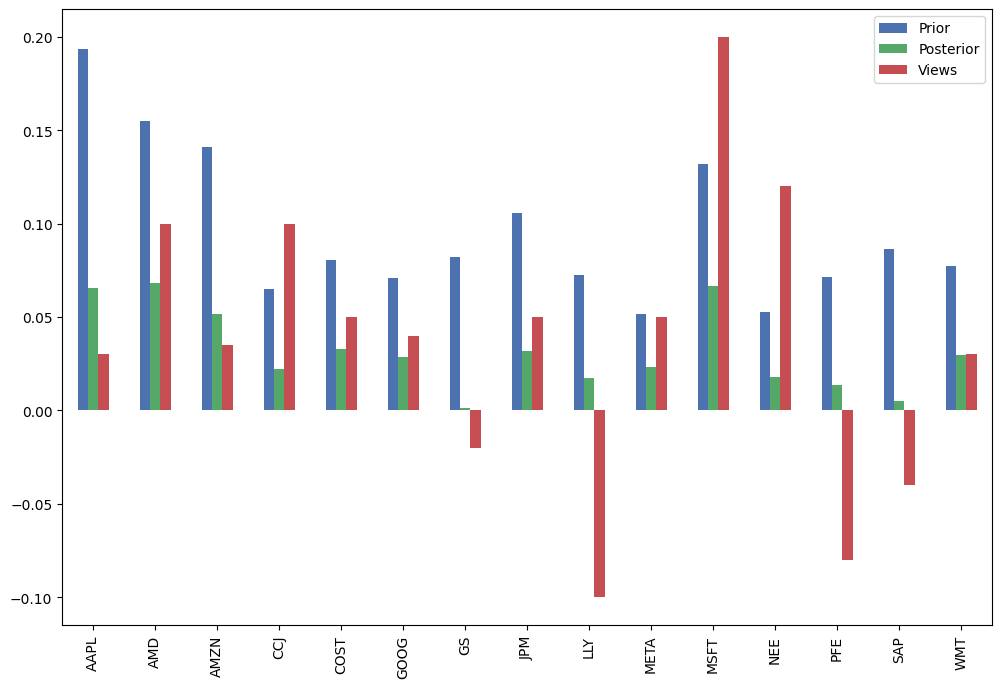

In [90]:
rets_df.plot.bar(figsize=(12,8))

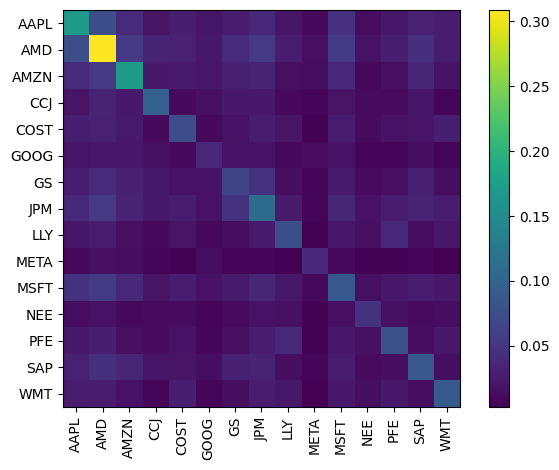

In [91]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [92]:
from pypfopt import EfficientFrontier, objective_functions

In [93]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

c:\Python310\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.22208),
             ('AMD', 0.20681),
             ('AMZN', 0.14664),
             ('CCJ', 0.0),
             ('COST', 0.05419),
             ('GOOG', 0.03719),
             ('GS', 0.0),
             ('JPM', 0.03732),
             ('LLY', 0.0),
             ('META', 0.00915),
             ('MSFT', 0.25024),
             ('NEE', 0.0),
             ('PFE', 0.0),
             ('SAP', 0.0),
             ('WMT', 0.03639)])

<Axes: >

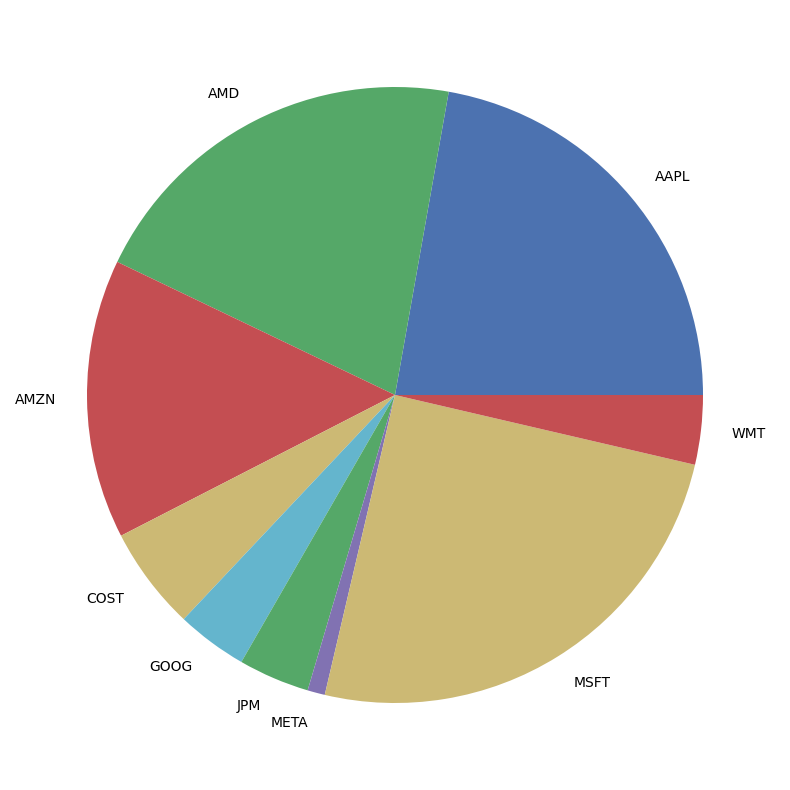

In [94]:
pd.Series(weights).plot.pie(figsize=(10,10))

In [95]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=1000000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $27.98


{'AAPL': 1188,
 'AMD': 1868,
 'AMZN': 1127,
 'COST': 103,
 'GOOG': 300,
 'JPM': 267,
 'META': 32,
 'MSFT': 737,
 'WMT': 234}